# HARKictecture

This notebook considers the design and implementation of the next generation of heterogenous agent model (HAM) notation.

In [1]:
%load_ext tikzmagic

**TODO**: Market rational expectations iteration algorithm and rationale.

**TODO**: Describe "expectation calculation" algorithm method for continuous space  in detail, including use of first order conditions and gridpoints.

**TODO**: time iteration

**TODO**: Some deeper notes on interpolation

**TODO**: Some deeper notes on distribution discretization



## Definitions

Unless otherwise stated, this analysis applies to additively separable problems only.

### Bellman Equation

A [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) is a formulation of the value to an agent of each state acting optimally within a dynamic decision problem. From this value function it is easy to compute the optimal policy for the agent. It has been "discovered" and used in many fields, and goes by many names and notational variations across disciplines (Powell, 2007).


The Bellman equation takes the form (**Definition 1**):

$$V(x) = \text{max}_{a \in \Gamma(x)} F(x,a) + \beta V(T(x,a))$$

Where:

* $a \in A$, the set of actions available
* $x \in X$, the set of states
* $\Gamma : X \rightarrow \mathscr{B}(A)$ constraints the actions available in state X
* $F: X \times A \rightarrow \mathbb{R}$ is the payoff to the agent of taking action $a$ in state $x$
* $T: X \times A \rightarrow X$ is a transition function determining the state in the next period
* $\beta$ is a discount factor on future payoffs. **Maybe $\beta: X \times A \rightarrow \mathbb{R}$**

This representation of Bellman equation assumes a deterministic model. If T is a stochastic function, $T_{i,j}: X_i \times A_i \rightarrow P(X_j)$, as it is in many cases in economics, then the value function is defined in terms of expectations. (**Definition 2**):

$$V(x) = \text{max}_{a \in \Gamma(x)} F(x,a) + E[\beta  V(T(x,a))]$$

We will use the deterministic version of this equation for simplicity unless there's a good reason to use the probabilistic version.

We define a policy $\pi: X \rightarrow A$ to be a function from state space to action space. A policy is, in effect, a guide to the action of an agent. The optimal policy for an agent, subject to discounting, will be defined in terms of the value function:

$$\pi^*(x) = \text{argmax}_{a \in \Gamma(x)} F(x,a) + E[\beta  V(T(x,a))]$$

#### Time and finitude.

Note that in the above definitions, there is only one state space, action space, value function, etc. that is repeated "over time". However, it is possible to model "changes over time" within this formalism by including an indicator of the "time" within the model in the state space. While these definitions are in this sense perfectly general, various desiderata have made alternative or reduced variations of this formalism desireable.

Though perhaps a source of confusion, we will note that the time index is often used explicitly in the definition of the Bellman equation, i.e.:

$$V_t(x) = \text{max}_{a \in \Gamma(x)} F(x,a) + E[\beta  V_{t+1}(T(x,a))]$$

This is especially the case when the equation is more "worked out" and the state space is articulated in terms of model variables (see below).

The explicit representation of time encourages the articulation of "finite horizon" models which have a notional maximal time limit. In theory, this is accomodated by the formalism above by stipulating that for all $\hat{t} > K$, $V_{\hat{t}} = 0$.

As we will see, as we constrain the space of Bellman problems to classes of problems with certain shared features, we can develop general solution algorithms that are more efficient at solving the problems. This motivates a deeper investigation of Bellman equations and their use in, e.g., economics.

### Solving the Model

Some basic background material on solution algorithms for Bellman problems.
For now this assumes discrete problem spaces, though we will ultimately be interested in continuous problem spaces.
**For now, I will presume that the time complexity of continuous problem solutions is comparable to the time complexity of their discretizations. Eventually I will include a formal analysis of this elaborating on e.g. Carroll (2006).**

#### Value Iteration

Perhaps the simplest algorithm for solving a problem in Bellman form is **value iteration**.
There are many varitions of value iteration. For the purposes of this preliminery analysis, we will examine one of the simplest.

1. Initialize $V(x) \leftarrow 0$ for all $x \in X$. (This initialization can be to any arbitrary value for an infinite horizon problem.)
2. Iteratively update until $\forall x, |V(x) - V'(s)| < 0$:
   1. $V' \leftarrow V$
   2. For all $x \in X$:
       1. For each $a \in \Gamma(x)$:
          1. compute $Q(a,x) \leftarrow F(x,a) + E[\beta  V'(T(x,a))$
       2. $V(x) \leftarrow \text{max}_{a \in \Gamma(x)} Q(a,x)$
3. Output optimal policy $\pi^*(x) \leftarrow \text{argmax}_{a \in \Gamma(x)} F(x,a) + E[\beta  V(T(x,a)) $

The computationally expensive part of value iteration is the update step (2.2). As written, the time complexity of one update step is $O(|X|^2|A|)$: a loop over the state space, a loop over the action space, and a final loop over the state space again in (2.2.1.1) to computer the expectated value from the next period.

However, it should be noted here that the algorithm implementation can take advantage of the sparsity of the problem. Not every combination of $(x, a, x')$ need be explored at each update step. Let $X'(x) = {x' |\exists a \in A, T(x,a)(x') > 0}$, the set of states in the next period that have a positive probability under the distribution $T(x,a)$. Then the complexity of the update step (2.2) for a given $x$ is reduced to $O(|\Gamma(x)||X'(x)|)$. Moreover, after a single pass ofr the state space at (2), it is possible to determine if some of the notional elements of $X$ are in fact never reached, and these can be excluded from future iterations.

An example of when a transition function will be sparse is when the "state" includes a variable that tracks the "time period" of the problem, $t$. As this model variable increments once per period with $T$, it adds no "width" to the problem at (2.2.1.1), and so can be added or removed without increasing the time complexity of the solution. In fact, the inclusion of this "variable" is often elevated to a role in primary notation, distinguishing different iterations of the problem's updating or simulation function, or as an alternative to the "prime" notation. As the use of this "time" notation has caused confusion in the past, where possible we will avoid it in these architecture notes.

#### Backwards induction

Backwards induction is in many respects even simpler than value iteration. In finite cases, the value function at each step can be computed directly starting with the terminal case. This looks much like value iteration as described above except that:
 * whereas in value iteration the initial $V$ is arbitrary, in the backwards induction case $V_K$ is given by the model definition.
 * whereas in value iteration the intermediary computed value functions are discarded, in backwards they are stored as $V_t$ is the unique solution at the $t$ time step.
 
 
#### Policy Iteration

More often than not economists use a version of _policy iteration_ to solve Bellman problems. While policy iteration has a worse time complexity per iteration step than value iteration, in practice it converges much faster. Policy iteration works by alternating estimation of the value function with estimation of the optimal policy.

1. Initialize $V(x)$ and $\pi(x)$ for all $x \in X$. (This initialization can be to any arbitrary value for an infinite horizon problem.)
2. Iterate until $\pi' = \pi$ with $\pi \leftarrow \pi`$:
    1. **Policy Evaluation**. For all $x \in X$, $V(x) \leftarrow F(x,\pi(x)) + E[\beta  V(T(x,\pi(x)))$
    2.  **Policy Improvement**. For all $x \in X$, $\pi'(x) \leftarrow \text{argmax}_{a \in \Gamma(x)} F(x,a) + E[\beta  V(T(x,a))]$

The time complexity for each iterations steps is: 

* For _Policy Evaluation_, for each state, fix the action, then loop over states again for expectations $O(|X||X'|)$ 
* For _Policy Improvement_, for each state, loop over each action, then over the states to compute expectations:  $O(|A||X||X')$.

As in Value Iteration, if the transition function is sparse then $X'$ will be small and the complexity of the problem will be reduced.

In practice, there are two main variations to this algorithm when applied to problems in economics:

* This definition of policy iteration assumes discrete state and action spaces. Many of the challenges of soving Bellman problems in economics come from the fact that these problems have continuous state and action spaces (such as quantities of money). For this reason, economists have developed methods for policy iteration with discrete approximation.
* The _Policy Improvement_ step has been so far assumed to be a grid search over the action space but for some forms of problem there may be more efficient ways of computing this function. (See endogenous gridpoint method (EGM) below)

**TODO**: How does this work on finite horizon problems?

#### Time Iteration / Coleman operators

**TODO**

https://www.mosphere.fr/files/papers/iti.pdf

https://python.quantecon.org/coleman_policy_iter.html

Useful in cases where there is no Bellman equation, such as in the New Keynesian model of the interest rate.

### Transition Equations and Structural Equation Modeling

In practice, economists rarely describe a model directly in terms of the formalism of Definition 1. Rather, they use a technique that can be considered a special case of Structural Equation Modeling to define the elements of the model. Consider the following simple example:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t} U(C_t) + \beta (1 - D_{t+1}) V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
A_t &=& M_t - C_t, \\
A_t/P_t &\geq& \hat{a}, \\
M_{t+1} &=& R A_t + Y_{t+1}, \\
Y_{t+1} &=& P_{t+1}, \\
P_{t+1} &=& G_{t+1} P_t.
\end{eqnarray*}


The equations below the value function definition (a Bellman equation) are called _transition equations_. These are a concise representation of the problem that includes information that is relevant to the transition function $T$ and constraint function $\Gamma$.

From these equations it is possible to reconstruct the problem in the form used in (Definition 1). This is a relatively simple example.

* $A = \mathbb{R}$ corresponds to $C$
* $X = \mathbb{R} \times \mathbb{R}$ corresponds to $(M, P)$
* $\Gamma((M, P)) = \{C | (M - C) / P \geq \hat{a}\}$
* $F((M,P),C) = U(C)$
* $T((M, P), C) = (R(M - C) + GP, GP)$
* $\beta$ is constant

We make several observations. First, the original transition equations are defined in terms of a set of variables. We will call these variables _model variables_. A model variable is not the same thing as an element of the Bellman problem; for example, the state space $X$ has two dimensions that correspond to the two variables $M$ and $P$.

It is conventional in economics to distinguish between _control variables_ and _state variables_. Here $C$ is a control variable because it is notionally chosen by the agent to maximize the value of the value function $V$. Control variables are thus related to the action space $A$ but not identical to it. For example, it is possible to have more than one control variable.

Note that the transition equations contains symbols (e.g., $Y$, $A$) that are not used in the definitions here. We will call these _state variables_ even though they do not show up in the state space $X$! **Do we need another name for this?**

This is a good reminder that _transition equations_ here are not the same thing as the _transition function_ $T$ of the Bellman problem, though they have similar names and are clearly connected. This is the source of some confusion. **We will clarify this relationship in later sections of this document.**

Note also that the substate $P$ never depends on the choice of an action. It grows at a rate of $G$ every period. We call variables that do not depend on an agent's choice _exogenous_ variables. **We will define this more carefully later in this document.**

#### Stochastic Transition Equations

The above example is deterministic and contains no stochastic shocks. The following problem introduces stochastic shocks to income and normalizes the problem.

The consumer receives two income shocks at the beginning of each period: a completely transitory shock $\theta$ and a completely permanent shock $\psi$.  Moreover, the agent is subject to borrowing a borrowing limit: the ratio of end-of-period assets $A_t$ to permanent income $P_t$ must be greater than $\hat{a}$.  This model is stated in terms of *normalized* variables, dividing all real variables by $P_t$:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} u(c_t) + \beta(1-D_{t+1})  \mathbb{E}_{t} \left[ (G_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\hat{a}$}, \\
m_{t+1} &=& R/(G_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

**TODO**: What is $F$ in the above equations?

It is worthwhile to note that normalization by the income level has reduced the state space of the problem from two dimensions to one. This is believed to reduce the time complexity of solving the problem, though it is possible that a well-defined solution algorithm could exploit the sparseness and exogeneity of the income transition function and achieve comparable performance with more generality.

However, what we are drawing attention to here is the use of stochastic _shocks_ $\theta$ and $\psi$ as model variables, which renders the entire problem probabilistic.

* $A = \mathbb{R}$ corresponds to $c$
* $X = \mathbb{R}$ corresponds to $m$
* $\Gamma(m) = \{c | m - c \geq \hat{a}\}$
* $F(m,c) = u(c)$
* $T(m, c) = R / (G \psi) (m - c) + \theta$
* $\beta$ is constant

Note the transition function $T$ is a stochastic function of the form $T: X \times A \rightarrow P(X)$. This function implies the existence of a conditional probability distribution $P_T(m' | m, c) = P_T(m' | m, c, \psi) P(\psi)$ because of the independence of $\psi$. The value function equation can be rewritten in terms of this distribution:

$$v(m) = \max_{c} u(c) + \beta(1-D) \mathbb{E}_{P_T} \left[ (G \psi)^{1-\rho} v'(m') \right]$$

Viewing the transition function in terms of its implied probability distribution over model variables will help us determine the general conditions for solution techniques to Bellman problems.


#### Graphical representation

These equations are structural: they describe _how the model works_. One consequence of this is that they have an implied causal direction. We could call these, equivalently, _causal equations_.

In fact, each structural equation defines a conditional probability distribution for the variable that is assigned on the left hand side. In many cases, the function is deterministic and so only degenerately probabilistic. However, this does not prevent us from using the well-developed tools of probabilistic graphical modeling that have been richly explored in artificial intelligence research.

Following the convention of Koller and Milch (2003), we will illustrate models that can be representated as causal graphical models with agents (what Koller and Milch call "multi-agent influence diagrams" or MAIDs) using:
 - ellipses for chance nodes (state variables)
 - rectangles for action nodes (control variables)
 - diamonds for utility variables (reward functions)
 
**TODO**: How to represent constraint sets $\Gamma$ in these illustrations?

Below is the graphical illustration of the stochastic shock model described above.

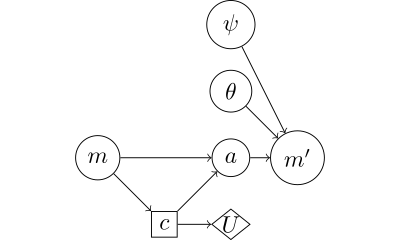

In [2]:
%%tikz -f svg
\usetikzlibrary{shapes}


\node[shape=circle,draw=black] (m) at (0,1) {$m$};

\node[shape=rectangle,draw=black] (c) at (1,0) {$c$};
\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt] (U) at (2,0) {$U$};

\node[shape=circle,draw=black] (a) at (2,1) {$a$};

\node[shape=circle,draw=black] (theta) at (2,2) {$\theta$};

\node[shape=circle,draw=black] (psi) at (2,3) {$\psi$};

\node[shape=circle,draw=black] (m_) at (3,1) {$m'$};


\path [->] (m) edge node[left] {} (c);

\path [->] (c) edge node[left] {} (U);

\path [->] (c) edge node[left] {} (a);
\path [->] (m) edge node[left] {} (a);

\path [->] (a) edge node[left] {} (m_);
\path [->] (theta) edge node[left] {} (m_);
\path [->] (psi) edge node[left] {} (m_);

## Approximation

Most of the problems of interest to economists have continuous domains for some or all of their state and action dimensions.

These models cannot be solved completely withotu infinite computing power.

We will allow users to specify the models in their real-valued form.

Then we will provide tools for approximating the model to make it tractable to solve.

By being explicit about the real-valued model, as well as the approximation techniques used, we will further enable reproducibility of scientific work in modeling.

Sometimes models will be defined with discrete domains, in which case those state and action values can be arrayed explicitly on a grid and iterated through directly.

### Approximating state and action spaces


Solution on a grid versus grid-based approximation of a continuum
Sometimes models are specified in ways that permit only specific values of state variables like wealth, which prohibits consumers from spending an amount that would leave them at any level of wealth that is not permitted. Sometimes, instead, the assumption is that there is a continuous function whose value is calculated at a finite number of points and interpolation or extrapolation is used to construct a value for it elsewhere.

#### Grids and Interpolation

The typical approximation technique for a continuous domain is to choose a set of 'gridpoints' in the state and action spaces $G(X), G(A)$

The value function $V$ can be computed at these gridpoints.

Intermediate values are approximated through interpolation.

This reduces the complexity of a _value function update_ step to $O(|G(X)||G(A)|)$.


#### Endogenous Gridpoints Method

Used to avoid computationally expensive rootfinding operations in the discovery of an optimal action in a continuous space. See Carroll, 2006.  Details of this method are in White, 2015.

The general form of problems that can solved with EGM varies the model above in the following ways:

* States space is divided into exogenous $W$ and endogenous $X$
* Name action space $Y$
* Risk is isolated to exogenous shock $S$
* Condition 1: Transition function $\Delta: W \times X \times Y \times S \rightarrow W \times X$ is decomposable into $\Xi: W \times X \times Y \rightarrow \mathbb{R}^n$ where $Z \subset \mathbb{R}^n$ and $\chi: W \times Z \times S \rightarrow X$ such that $\Delta^X(w,x,y,s) = \chi(w, \Xi(w, x, y), s))$
* (Other conditions)


**TODO**: Tie this into the preceding analysis. In particular, the pre/post-state distinction connects to the preceding work....how?



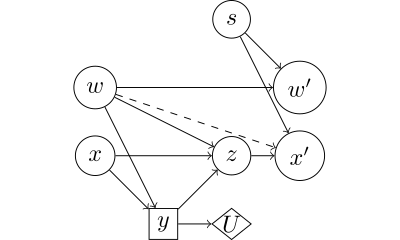

In [3]:
%%tikz -f svg

\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (w) at (0,2) {$w$};
\node[shape=circle,draw=black] (x) at (0,1) {$x$};

\node[shape=rectangle,draw=black] (y) at (1,0) {$y$};

\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt] (U) at (2,0) {$U$};


\node[shape=circle,draw=black] (z) at (2,1) {$z$};

\node[shape=circle,draw=black] (s) at (2,3) {$s$};

\node[shape=circle,draw=black] (w_) at (3,2) {$w'$};
\node[shape=circle,draw=black] (x_) at (3,1) {$x'$};

\path [->] (w) edge node[left] {} (z);
\path [->] (x) edge [] node[right] {} (z);
                                              
\path [->] (w) edge node[left] {} (y);
\path [->] (x) edge [] node[right] {} (y);                                              
                                              
\path [->] (y) edge [] node[right] {} (z);
\path [->] (y) edge [] node[right] {} (U);

\path [->] (s) edge [] node[right] {} (w_);                                              
\path [->] (w) edge [] node[right] {} (w_);

\path [->][style=dashed] (w) edge  node[left] {} (x_);
\path [->] (s) edge [] node[right] {} (x_); 
\path [->] (z) edge [] node[right] {} (x_);

**TODO** Is the dotted edge necessary?

Thus, the EGM is another example of a _decomposition_ of a problem into a simpler problem based on its topology.

**TODO**: Question: Why does EGM recommend solving the Bellman equation $V(x,y) = f(\mathbb{E}(V'(w, x,y))$ rather than decomposing the problem into computing $V_t( z )$ then computing $V_t(x,y) = g(V_t(z | w, x,y)$? Computing the first requires an integration but no control variables $V_t(z) = \int V_t(w, x | z) =  \int V_t(x | w, z) dw$; then computing the second requires no integration because the functions are deterministic.

### Approximating random variables

Random variables, which may occur in the structural equations for exogenous shocks, can be continuously valued -- such as the LogNormal variable.

In practice, these are often discretized for the purpose of forward simulation and/or the taking of expectations.

Several discretization methods are used:

#### Equiprobable

#### Gauss-Hermite


### Domains

In principle, the domains of values can be infinite. The challenge is to be explicit about how to extrapolate beyond the uppermost gridpoints.

## Developing the Framework

### Variations

The above formulation of the Bellman equation assumes that the problem is structured identically at every control point (opportunity for the agent to choose an action $a$) and that there is only one control point. For various applications in economics, we are interested in other kinds of problems, such as those with:

* **V1**. Sequential control points
* **V2**. Finite Problems Changing Over Time

While it may be tempting to consider these the same kind of challenge, we will examine each case rigorously in isolation and see if that conclusion can be confirmed.

#### V1. Sequential control points

**TODO: Under what conditions can a problem with multiple control variables be decomposed?!?!**

There are many Bellman problems with multiple "control variables". According to the formalism in **Definition 1**, this means that the action space $A$ has multiple dimensions. In the SEM framework, this entails multiple model variables defined to be controls.

Under some conditions (**TODO: What conditions?**) it is possible to decompose these problems into multiple subproblems with distinct value functions, state spaces, contraints, and transition functions. We will call this a "sequential control points" problem, or **V1** (Variation 1). 

For reasons connected to those described in "Mathematics of Discrete Time Stochastic Control Processes in Macroeconomics", problems of the following form, for $C$ (sequential) control variables, can be shown to have an equivalent problem in the above form: (Note that the variables here are in italic font)

* $(\mathit{A}_0, ..., \mathit{A}_C)$ is a sequence of sets of action spaces such that $A = \mathit{A}_0 \times ... \times \mathit{A}_c$
* $(\mathit{X}_0, ...,\mathit{X}_C)$ is a sequence of sets of state spaces such that $X = \mathit{X}_0 \times ... \times \mathit{X}_c$
* $(\mathit{\Gamma}_0, ..., \mathit{\Gamma}_C)$ is a sequence of contraints. $\mathit{\Gamma}_c: \mathit{X}_c \rightarrow \mathscr{B}(\mathit{A}_c)$
* $(\mathit{F}_0, ..., \mathit{F}_C)$ is a sequence reward functions. $\mathit{F}_c: \mathit{X}_c \times \mathit{A}_c \rightarrow \mathbb{R}$
* $(\mathit{T}_0, ..., \mathit{T}_C)$ is a sequence of transitions functions $\mathit{T}_c: \mathit{X}_c \times \mathit{A}_c \rightarrow \mathit{X}_{(c+1) mod C}$. **Note incrementing of state space in transition function.**
* $(\mathit{\beta}_0, ..., \mathit{\beta}_C)$ a potentially varying discount factor

With these sequences of subproblems defined, the decomposed into $C$ mutually recursive Bellman-like *Carroll equations* (**Definition 3**) for $x \in \mathit{X}_c$ is:

$$\mathit{V}_c(x) = \text{max}_{a \in \mathit{\Gamma}_c(x)} \mathit{F}_c(x,a) + \mathit{\beta}_c \mathit{V}_{(c+1) mod C}(\mathit{T}_c(x,a))$$

In principle, the original problem could be defined in such a way that the sub-problems need not have a natural sequential order. However, in these cases multiple ordering will suffice.

Note that these subproblems are not isolated from each other. The transition function $\mathit{T}_c$ of each problem contains a "reference" to the state space in the next "stage" $\mathit{X}_{c+1}$.

These truly are "subproblems" of the original problem specification, as the original specification can be reconstituted from the details of the subproblems. For example, $A = \mathit{A}_0 \times ... \times \mathit{A}_c$, $X = \mathit{X}_0 \times ... \times \mathit{X}_c$ and so on. The problem remains an infinite horizon problem, but decomposed into $C$ simpler sub-problems with reduced action and state spaces.

##### Example: Portfolio consumption problem

**Unfinished. Requires translation into the above formalism.**

Consider this version of the portfolio choice consumption saving problem.

**TODO**: Complete this table with the elements from Definition 3.

**PROBLEM**: What about $p$ in this formulation? Is it a state variable? Should it be added to the state space?

Variable | Equation | Operation | Stage | Utility | Constraints
-- | -- | -- | -- | -- | --
$\eta$| ~Dist | Shock | c | -- | --
$\theta$ | ~Dist | Shock | c | -- | --
$\psi$ | ~Dist | Shock | c | -- | --
$\hat{R}$ | $$\hat{R} = \alpha * \eta + (1 - \alpha) * R$$ | Update | $c$ | -- | --
$b$ | $$b_{t} = a_{t-1} \hat{R}$$ | Update | c | -- | --
$p$ | $$p_{t}=p_{t-1}\psi_{t}$$ | Update | c | -- | --
$y$ | $$y_{t} = p_{t}\theta_{t}$$ | Update | c | -- | --
$m$ | $$m_{t} = b_{t} + y_{t}$$ | Update | c | -- | --
$c$ | $c$ | Control | c | U(c) | $c \leq m$
$a$ | $$a_{t} = m_{t} - c_{t}$$ | Update | $\alpha$ | -- | --
$\alpha$| $\alpha$ | Control | $\alpha$ | 0 | $0 \leq \alpha \leq 1$

This can be decomposed into two subproblems ("stages"). The consumption stage:

* $c \in A_0 = \mathbb{R}$
* $m \in X_0 = \mathbb{R}$
* $\Gamma_0$ ... restricts consumption $c \leq m$
* $F_0(m,c) = CRRA(c)$
* $T_0(m,c) = m - c $ 
* $\beta_0 = 1 $

The allocation stage:

* $\alpha \in A_1 = \mathbb{R}$
* $a \in X_1 = \mathbb{R}$
* $\Gamma_\alpha$ ... restricts allocation $0 \leq \alpha \leq 1$
* $F_\alpha(a,\alpha) = 0$
* $T_\alpha(a,\alpha) = \hat{R} a + \psi \theta p $ ... **ERROR: p is undefined in state space**
* $\beta_\alpha = \beta $

This is a representation of this problem's structural equations as a graphical model.

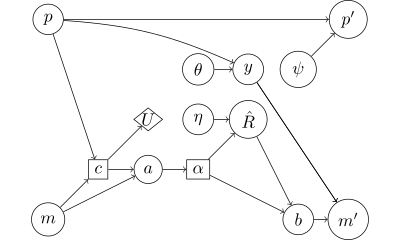

In [4]:
%%tikz -f svg
\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (eta) at (3,2) {$\eta$};

\node[shape=circle,draw=black] (m) at (0,0) {$m$};
\node[shape=circle,draw=black] (p) at (0,4) {$p$};

\node[shape=rectangle,draw=black] (c) at (1,1) {$c$};

\node[shape=circle,draw=black] (a) at (2,1) {$a$};

\node[shape=rectangle,draw=black] (alpha) at (3,1) {$\alpha$};
\node[shape=circle,draw=black] (Rport) at (4,2) {$\hat{R}$};

\node[shape=circle,draw=black] (b) at (5,0) {$b$};

\node[shape=circle,draw=black] (theta) at (3,3) {$\theta$};
\node[shape=circle,draw=black] (y) at (4,3) {$y$};
\node[shape=circle,draw=black] (psi) at (5,3) {$\psi$};

\node[shape=circle,draw=black] (m_) at (6,0) {$m'$};
\node[shape=circle,draw=black] (p_) at (6,4) {$p'$};

\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt] (U) at (2,2) {$U$};

\path [->] (m) edge node[left] {} (c);
\path [->] (p) edge node[left] {} (c);

\path [->] (c) edge node[left] {} (U);

\path [->] (c) edge node[left] {} (a);
\path [->] (m) edge node[left] {} (a);
                                              
\path [->] (a) edge node[left] {} (alpha);
                                              
\path [->] (eta) edge node[left] {} (Rport);                                              
\path [->] (alpha) edge node[left] {} (Rport);
\path [->] (alpha) edge node[left] {} (b);
\path [->] (Rport) edge node[left] {} (b);

\path [->] (p) edge [bend left = 10] node[left] {} (y);  
\path [->] (theta) edge node[left] {} (y);
\path [->] (y) edge node[left] {} (m_);
\path [->] (psi) edge node[left] {} (p_);
\path [->] (b) edge node[left] {} (m_);
\path [->] (y) edge node[left] {} (m_);
\path [->] (p) edge node[left] {} (p_);


This is a representation of the problem decomposed into _stages_, represented by hexagons.

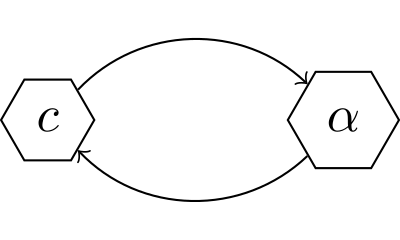

In [5]:
%%tikz -f svg

\usetikzlibrary{shapes}

\node[regular polygon, regular polygon sides=6, draw=black] (c) at (0,0) {$c$};
\node[regular polygon, regular polygon sides=6,,draw=black] (alpha) at (2,0) {$\alpha$};

\path [->] (c) edge [bend left=45] node[left] {} (alpha);
\path [->] (alpha) edge [bend left=45] node[right] {} (c);

**TODO** Time discounting is after the $\alpha$ step.

#### V2. Finite Problems Changing Over Time

There is a sense in which the challenge of changing over time is similar to the challenge of multiple control points. We will see that the formal descriptions of the challenges are similar. However, there are some differences:

1. Whereas multiple control points allow us to break a problem down into $C$ subproblems with smaller state and action spaces than the original problem, inconsistency over time makes a problem *more* complex because it *increases* the size of the problem and set of problems that can be represented.
2. One of these things will hold for any actually specified inconsistent problem: (a) the inconsistent problem is a finite problem, or (b) the inconsistent problem can be rewritten as a consistent problem with time index in its state space.

We will formally define the time inconsistent problem in terms of the following, assuming for now that it is a finite problem:

* $A_0, ..., A_K$ is a sequence of sets of action spaces
* $X_0, ...,X_K$ is a sequence of sets of state spaces
* $\Gamma_0, ..., \Gamma_C$ is a sequence of contraints. $\Gamma_k: X_k \rightarrow \mathscr{B}(A_k)$
* $F_0, ..., F_K$ is a sequence reward functions. $F_k: X_k \times A_k \rightarrow \mathbb{R}$
* $T_0, ..., T_K$ is a sequence of transitions functions $T_k: X_k \times A_k \rightarrow X_{k+1}$, with $T_K$ undefined. (see below for value function construction).
* $\beta_0 , ..., \beta_K$, a (potentially varying) discount factor for utility between time steps 

Specific changes to the formalism include:

* *Substance*: Whereas in V1 the problems are defined by mutual recursive with $\mathit{T_C}: \mathit{X}_C \times \mathit{A}_C \rightarrow \mathit{X}_0$, in this case $T_K$ is terminal.
* *Notation*: Whereas in V1 the subproblem components were written in a different font `mathit` (**perhaps too subtle a difference; could use mathcal instead?**), these subproblems are not a valid decomposition of single, more complex infinite horizon problem and so use the standard font.


With these sequences of subproblems defined, the Bellman-like *Carroll equations* are:

$$V_K(x) = \text{max}_{a \in \Gamma_K(x)} F_K(x,a)$$
$$V_k(x) = \text{max}_{a \in \Gamma_k(x)} F_k(x,a) + \beta_k V_{k+1}(T_k(x,a))$$

Because this is a finite model, this can be solved simply via backwards induction without looking for a convergent value of $V_k$. Note that as before, the transition functions $T_k$ link the problem at $k$ to the state space of the next time $X_{k+1}$.

If the problem for any $k$ carries as much information as one problem in the mode of **Definition 1**, then the time inconsistent problem will have a longer minimum description lengtht than the original infinite horizon problem. This is in contrast to the decomposition of the infinite horizon problem in to multiple stages based on multiple control variables; in the latter case, the decomposition contains no new information.

### Carroll Problems: a proposed unified formalism
   
The two variations on the classic Bellman equation above have clear formal similarities, though they have some important differences as well. For the sake of clarity, we will formally define a *Carroll Problem* in a way that both kinds of variation, and others besides it, can be represented easily.

#### Deterministic case

A Carroll Problem $\mathbb{C}$ is a set of subproblems $\{\mathcal{C}_0, ... \mathcal{C}_I\}$.

Each subproblem $\mathcal{C}_i = (A_i, X_i, \Gamma_i, F_i, j, T_i, \beta_i)$ or **stage** is a tuple of the following:

* A definition of the local problem:
    * $A_i$, the set of actions available
    * $X_i$, the set of states
    * $\Gamma_i : X \rightarrow \mathscr{B}(A)$ constraints the actions available in state X
    * $F_i: X \times A \rightarrow \mathbb{R}$ is the payoff to the agent of taking action $a$ in state $x$
* A information about the transition to the next problem. This could be:
    * Null, in which case the problem is terminal, or ...
    * A tuple containing:
        * An index to another subproblem $j$
        * $T_i: X_i \times A_i \rightarrow X_j$, a transition function determining the state in the next problem
        * $\beta_i$ is a discount factor on future payoffs.

The Carroll problem (**Definition 6**) can then be solved using backwards induction by computing the value functions $V_i : X_i \rightarrow \mathbb{R}$:

$$V_i(x) = \text{max}_{a \in \Gamma_i(x)} F_i(x,a) + \beta_i V_{j}(T_i(x,a))$$

or for the terminal subproblems

$$V_i(x) = \text{max}_{a \in \Gamma_i(x)} F_i(x,a)$$

Note that the connection between subproblems can be represented as a directed graph in the case of repetitions.

**Quandary**. How does one represent an infinite horizon problem with a "terminal solution" ?

An infinite horizon problem: $T(X_0, A_0) \rightarrow X_0$. Derive optimal $\pi^*_0$ as solution.

$$V_0(x \in X_0), T(X_0, A_0) \rightarrow X_1$$

$$V_1(x \in X_1)$$

Cases:

* 1 stage, repeated $\infty$ - infinite horizon
* C stages, repeated $\infty$ - e.g. seasonal
* 1 stage, repeated $K$ - e.g lifecycle. finite horizon
  - or $K$ stages, 1 time. finite horizon
* C stages, repeated $K$ - embeded finite

-----------------

This is not a case we need to support soon.
* C stages, repeated $\infty$, repeated $K$

#### Stochastic transitions

As discussed above, by extending only the *transition* aspect of the problem, we can introduce stochasticity.
Here, we introduce not only stochasticity not only within the state space of the "next problem", but also stochasticity between the indices of the next problem.

Each subproblem $\mathcal{C}_i$ is a tuple of the following:

* A definition of the local problem:
    * $A_i$, the set of actions available
    * $X_i$, the set of states
    * $\Gamma_i : X \rightarrow \mathscr{B}(A)$ constraints the actions available in state X
    * $F_i: X \times A \rightarrow \mathbb{R}$ is the payoff to the agent of taking action $a$ in state $x$
* A information about the transition to the next problem. This could be:
    * Null, in which case the problem is terminal, or ...
    * A tuple containing:
        * $P_J$, a probability distribution over indices to other subproblems $j$
        * $T_{i,j}: X_i \times A_i \rightarrow P(X_j)$, a transition function determining the state in the next problem. Note the output of the transition function is a probability distribution over states $X_j$ given problem $j$.
        * $\beta_i$ is a discount factor on future payoffs. 
        
The value function (**Definition 8**) is then:

$$V_i(x) = \text{max}_{a \in \Gamma_i(x)} F_i(x,a) + E_{P_J}[\beta_i V_{i,j}(T_{i,j}(x,a))]$$

#### Endogenous stage transitions

As a variation, stage transitions could be endogenous. This would be similar to the above, but with:

Let $P_J: X \times A \rightarrow P(J)$ vary with state and action choices.

#### Endogenous discount factor

Allow $\beta: X \times A \rightarrow \mathbb{R}$ or, stochastically, to a probability distribution.

See Kim and Kose (2003).

##### Example: Consumption with mortality

The infinite horizon consumption saving problem with a .02 mortality rate.

The problem $d$ is terminal and allows no actions or utility.

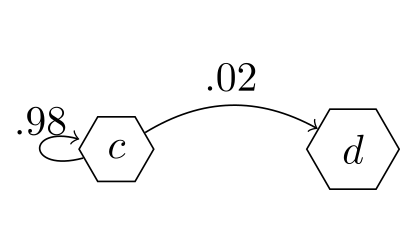

In [6]:
%%tikz -f svg

\usetikzlibrary{shapes}

\node[regular polygon, regular polygon sides=6,draw=black] (c) at (0,0) {$c$};
\node[regular polygon, regular polygon sides=6,draw=black] (d) at (2,0) {$d$};

\path [->] (c) edge [loop left] node[above] {.98} (c);
\path [->] (c) edge [bend left] node[above] {.02} (d);

Alternatively, mortality in the single agent problem can be modeled with a change in discount factor to 0.

## Multiple agents

### Aggregate Shocks

The simplest form of multi-agent problem involves multiple agents that never interact. They are united into "the same problem" one by an aggregate exogenous shock or process that is shared in common by the agents as they solve their own problems.

Consider a problem with $N$ agents each with a single stage or Carroll subproblem \mathcal{C} that is repeated infinitely. The conditions for the new stage are set in part by an exogenous aggregate process $A$ that also updates in time.

This is illustrated in the graph below. Here, we use the **hexagon** to represent a Carroll subproblem or stage, as before. We also introduce **plate notation** to indicate when there are multiple (here $N$) copies of the variable represented.

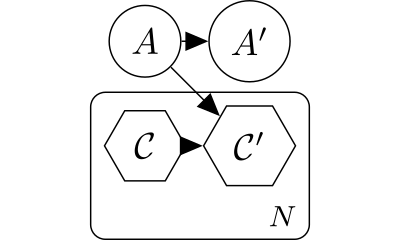

In [7]:
%%tikz -f svg
\usetikzlibrary{bayesnet}

% Define nodes
\node[circle,draw=black] (A) at (0,1) {$A$};
\node[circle,draw=black] (A_) at (1,1) {$A'$};
\node[regular polygon, regular polygon sides=6,draw=black] (C) at (0,0) {$\mathcal{C}$};
\node[regular polygon, regular polygon sides=6,draw=black] (C_) at (1,0) {$\mathcal{C}'$};

 % Connect the nodes
\path [->] (A) edge node[left] {} (C_);
\path [->] (C) edge node[left] {} (C_);
\path [->] (A) edge node[left] {} (A_);

% Plates
\plate {C} {(C)(C_)} {$N$} ;

### Actual Macroeconomics: Market Equilibria

Arguably, a problem is not truly a macroeconomic problem until it involves some interaction between agents via a market. This introduces a lot of complications.

Consider a set of agents with a single Carroll problem or stage that encounter aggregate effects through a market mechanism.

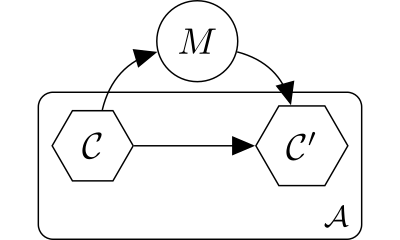

In [8]:
%%tikz -f svg
\usetikzlibrary{bayesnet}

% Define nodes
\node[circle,draw=black] (M) at (1,1) {$M$};
\node[regular polygon, regular polygon sides=6,draw=black] (C) at (0,0) {$\mathcal{C}$};
\node[regular polygon, regular polygon sides=6,draw=black] (C_) at (2,0) {$\mathcal{C'}$};


 % Connect the nodes
\path [->] (C) edge [bend left] node[left] {} (M);
\path [->] (M) edge [bend left] node[left] {} (C_);
\path [->] (C) edge  node[left] {} (C_);
% Plates
\plate {C} {(C)(C_)} {$\mathcal{A}$} ;

Macroeconomics most frequently assumes that agents have _rational expectations_, meaning expectations that are consistent with the formal model being analyzed. In this case, that implies that all agents $a \in \mathcal{A}$ must be in equilibrium with respect to each other's strategies.

This is more computationally challenging than the single-agent game. It can be approached in a number of ways.

#### The Way HARK Does It

HARK solves this multi-agent aggregation game using an iterated Monte Carlo simulation method. The method is in two steps.

**Step 1**. Initializing some market "dynamics" expectations $M$, solve for each agent $a \in \mathcal{A}$ the 'single agent' problem of finding optimal policy $\pi^*_a$ as if the market was an exogenous shock.

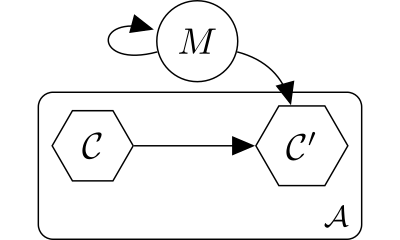

In [9]:
%%tikz -f svg
\usetikzlibrary{bayesnet}

% Define nodes
\node[circle,draw=black] (M) at (1,1) {$M$};
\node[regular polygon, regular polygon sides=6,draw=black] (C) at (0,0) {$\mathcal{C}$};
\node[regular polygon, regular polygon sides=6,draw=black] (C_) at (2,0) {$\mathcal{C'}$};


 % Connect the nodes
\path [->] (M) edge [loop left] node[above] {} (M);
\path [->] (M) edge [bend left] node[left] {} (C_);
\path [->] (C) edge  node[left] {} (C_);
% Plates
\plate {C} {(C)(C_)} {$\mathcal{A}$} ;

**Step 2**. With the policies $\pi^*_a$ in hand, then use the policy to _induce the Carroll problem_ $\mathcal{C}$ into a multivariate probability distribution. Then _simulate forward_ to generate a new set of market expectations $M'$.

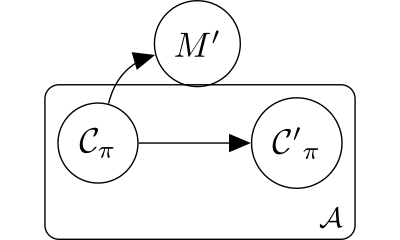

In [10]:
%%tikz -f svg
\usetikzlibrary{bayesnet}

% Define nodes
\node[circle,draw=black] (M_) at (1,1) {$M'$};
\node[circle,draw=black] (C) at (0,0) {$\mathcal{C}_\pi$};
\node[circle,draw=black] (C_) at (2,0) {$\mathcal{C'}_\pi$};


 % Connect the nodes
\path [->] (C) edge [bend left] node[left] {} (M_);
\path [->] (C) edge  node[left] {} (C_);
% Plates
\plate {C} {(C)(C_)} {$\mathcal{A}$} ;

**Step 3**. Repeat Steps 1 and 2 until convergence of $M$ and $M'$.

This method will not converge under all conditions.

### Game Theory: Multi-Agent Influence Diagrams

When the structural equation form of the dynamic stochastic problem is used, it is not difficult to include multiple agents explicitly in the model. Following Koller and Milch (2003), we can define a set of agents $\mathcal{A} \ni a$ and assign control variables to that agent. Utility functions/nodes can also be assigned to agents.


For example, suppose that in the portfolio problem consumption and portfolio allocation were performed by different agents. Agent $a$, the consumer, has a lower risk aversion rate than $b$, the investor; $\rho_a < \rho_b$. Because they have different utility rates, they optimize their actions differently. They must take each other's behavior into account when deciding their rational actions. Graphically, the agent assignments can be represented by node fill colors.

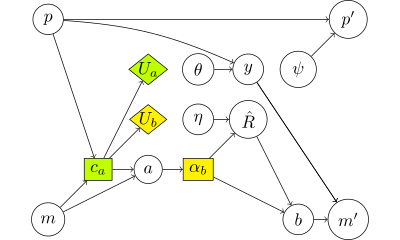

In [11]:
%%tikz -f svg
\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (eta) at (3,2) {$\eta$};

\node[shape=circle,draw=black] (m) at (0,0) {$m$};
\node[shape=circle,draw=black] (p) at (0,4) {$p$};

\node[shape=rectangle,draw=black, fill=lime] (c) at (1,1) {$c_a$};

\node[shape=circle,draw=black] (a) at (2,1) {$a$};

\node[shape=rectangle,draw=black, fill=yellow] (alpha) at (3,1) {$\alpha_b$};
\node[shape=circle,draw=black] (Rport) at (4,2) {$\hat{R}$};

\node[shape=circle,draw=black] (b) at (5,0) {$b$};

\node[shape=circle,draw=black] (theta) at (3,3) {$\theta$};
\node[shape=circle,draw=black] (y) at (4,3) {$y$};
\node[shape=circle,draw=black] (psi) at (5,3) {$\psi$};

\node[shape=circle,draw=black] (m_) at (6,0) {$m'$};
\node[shape=circle,draw=black] (p_) at (6,4) {$p'$};

\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt, fill=lime] (U_a) at (2,3) {$U_a$};
\node[shape=diamond,draw=black, aspect=1.25, inner sep=0pt, fill=yellow] (U_b) at (2,2) {$U_b$};

\path [->] (m) edge node[left] {} (c);
\path [->] (p) edge node[left] {} (c);

\path [->] (c) edge node[left] {} (U_a);
\path [->] (c) edge node[left] {} (U_b);

\path [->] (c) edge node[left] {} (a);
\path [->] (m) edge node[left] {} (a);
                                              
\path [->] (a) edge node[left] {} (alpha);
                                              
\path [->] (eta) edge node[left] {} (Rport);                                              
\path [->] (alpha) edge node[left] {} (Rport);
\path [->] (alpha) edge node[left] {} (b);
\path [->] (Rport) edge node[left] {} (b);

\path [->] (p) edge [bend left = 10] node[left] {} (y);  
\path [->] (theta) edge node[left] {} (y);
\path [->] (y) edge node[left] {} (m_);
\path [->] (psi) edge node[left] {} (p_);
\path [->] (b) edge node[left] {} (m_);
\path [->] (y) edge node[left] {} (m_);
\path [->] (p) edge node[left] {} (p_);

Solving this problem is somewhat complex because it involves finding the Nash Equilibrium of decision rules for $c_a$ and $\alpha_b$. However, a good generalized backwards induction method for probabilistic graphical models should be able to handle this.

In practice, macroeconomists have been shy of the computational complexity of strategic equilibria and so have relied on models of market equilibria in which strategic interaction is limited due to the modeling assumptions or network topology.

There are no special steps needed to _solve_ these kinds of problems, because to the individual agent that aggregate shock can be handled much like an individual shock. The relevance of the aggregate shock is mainly in forward simulation, as it introduces correlations between the agent's behavior and outcomes.

### Other variations

There are other ways to vary the way dynamic problems get defined. New variations might either (a) allow for a more parsimonious expression of problems in a more restricted class, or (b) allow for the expression of entirely new kinds of problems.

#### Normalized

---


#### Irrational expectations

There are some models where we would like agents to have irrational expectations. For example, if they have incorrect views about the stock market's risky returns.

A simple approach to the problem is to solve the problem with one set of parameters and then forward simulated using that policy in a problem with new parameters.

#### Recursive preferences

An example of a class of problems that are not additivitely separable would be recursive preferences. See for instance Section 3, "the time aggregator" [here](http://w4.stern.nyu.edu/economics/docs/workingpapers/2005/BRZ%20palgrave.pdf).

#### Endogenous information flow

A more complex and interesting way to address this is to have endogenous limitations of information flows within the model.

#### Strategic agents

Multiple interacting agents with different reward functions. Game theoretic or evolutionary equilibria. Build on Koller and Milch (200X).

In [12]:
## Visualizing the relationship between subproblems of Portfolio Consumption

### General Modeling Desiderata

Once we have all of the information necessary to define a problem, we may be inclined to reshape it into a more tractable form. In general, we would like our models to be easy to understand and easy to solve. These two desiderata may be at odds with each other and can be addressed separately.

* D1. Minimal computational complexity of solution
* D2. Minimal programmatic description.

#### D1. Minimal computational complexity of solution

The main technique used to reduce the computational complexity of solving the dynamic optimization is by reducing the size of a problem by decomposing it into equivalent subproblems.

For example, it is sometimes possible to reduce a two-dimensional state space into a single dimension where one state dimension is normalized by the other.


##### Action space reduction

If the action space of the original problem has 2 dimensions, but the problem can be decomposed into two problems with 1 dimensional action spaces, this reduces the complexity of the problem from (roughly speaking) $O(n^2)$ to $O(n)$, a significant reduction.

##### State space reduction

If the original problem has a state space of 5 dimensions, if the problem can be reduced to 2 dimensions, that reduces the time and space complexity of the problem.

Hence, wherever possible, it is beneficial to decompose a repeated problem with a large action space into Carroll subproblems.

#### D2. Minimal programmatic description



## Dolo in depth


_Dolo is always changing. In defining the scope of problems that Dolo solves, we must specify a version number_.

[Old Dolo Manual](https://buildmedia.readthedocs.org/media/pdf/dolo/doc/dolo.pdf)

**Note:** Dolo supports _multiple control variables_ in a model, i.e. a multidimensional actions space. See for example its canonical [Real Business Cycle](https://github.com/EconForge/dolo.py/blob/master/examples/models_/rbc2.yaml) model. However, it does _not_ yet support the "sequential control variable" method of problem decomposition, which we conjecture to have significant performance improvements over the simultaneous multiple control models.


### Matrix methods

Dolo uses matrix-based methods for both solving and simulating economic models.

### The model object


Dolo supports the definition of problems using the following constructs:

* [symbols](https://dolo.readthedocs.io/en/latest/model_api.html#symbols): the definition of mathematical symbols. These correspond to:
  * dimensions of the action space $A$
  * dimensions of the [state space](https://dolo.readthedocs.io/en/latest/model_specification.html#state-space) $X$
  * other parameters used
* [calibration](https://dolo.readthedocs.io/en/latest/model_api.html#calibration): a dictionary of parameters giving values to symbols.
* [functions](https://dolo.readthedocs.io/en/latest/model_api.html#functions): contains several functions that define other aspects of the problem
* domain: Domain
* [exogenous](https://dolo.readthedocs.io/en/latest/model_api.html#exogenous-shock): A driving Process that changes over time

The domain of the exogenous state is implicit in the processes used. These are never used.

The endogenous state boundaries are given in a separate part of the YAMl syntax:

```
domain: 
 - x : [min,max]

```

The most informative aspect of the model is contained in the `functions` dictionary, which should be described in greater detail.

#### Dolo functions

Within the `functions` dictionary a modeler can put a number of named functions. These functions are defined over variables in the state, action, and parameters space enumerated in the `symbols` dictionary. We will note here how each element corresponds to an aspect of the Bellman equation formalism.

- `felicity`. The reward function per time period, without discount, in the Bellman form value function.
   - state, control, parameters -> [vector of reals]^1
   - corresponds to $F$
- `value`. Thereward/felicity plus the discounted value of the next period (recursive).
   - state, control, parameters -> [vector of reals]^1
   - corresponds to $V$
- `transition` The transistions of the endogenous states as a function of their value in the previous time period, exogenous, and control.
   - exogenous_state,  endogenous_state, controls, exogenous_state_today, parameters -> endogenous_state
   - corresponds to $T$
- `arbitrage`. The first order conditions of the maximization conditions of the problem, the Euler equations. A nonlinear system of equations that needs to be 0 at the maximum (or the minimum, which we hope it's not) or a boundary. There are as many equations as there are control variables.
   - endo_state, exo_state, controls, Tomorrow endo_state, Tomorrow_exo_state, Tomorrow_controls, parameters -> [vector of size of controls]
   -  Can contain information about the boundaries for the controls. Complementarity conditions. Constraints. I.e. `0 <= n < inf`. This can be replaced with `controls_lb`.
   - corresponds to a _solution_ to $V$ **(???)**
   - ... and possibly the contraints object $\Gamma$
- `expectation`. **Specifically for Parameterized Expecation method**. An expecation of the future.
   - exo_state, endo_state_tomorow, controls_tomorrow -> [size of expectations vector]
   - size of output is set in the symbols dictionary
   - corresponds to the expectations clause $\mathbb{E}\[V(T(x,a)\]$ in the value function **(???)**
- `direct_response`. The optimal control response given expectations of future actions and state today.
   - exo_state, endo_state, paramaters  -> controls
   - corresponds to a _solution_ to $V$ **(???)**
- `controls_lb` and `controls_ub`. Lower and upper bounds for the controls.
   - endo_state, exo_state  -> a vector of the lower/upper bounds of each control
   - corresponds to the contraints object $\Gamma$
- `terminal_conditions` : in case the model is finite, controls in the last period. [link](https://dolo.readthedocs.io/en/latest/model_specification.html#terminal-conditions)
   


### Solution algorithms

Dolo supports a variety of solution algorithms. These algorithms require a model object as designed above, along with a subset of the allowable functions. The algorithms have different function requirements as follows:

* Time iteration: `transition` and `arbitrage`
* Improved time iteration: `transition` and `arbitrage`
* Perfect foresight: `transition` and `arbitrage`
* Perturbation : `transition` and `arbitrage`
* Steady state : `transition` and `arbitrage`
* Value function iteration : `transition`, and either a `felicity` or `value`
* Parameterized expectations : `transition`, `expectation`, and `direct response`

## Pablo's proposal

Elements of Pablo's proposal.

### Problem setup: discrete and continuous spaces

* $m \in M$ discrete state
* $a \in A$ discrete action
* $s \in \mathcal{S}(m,a)$ continuous state
* $x \in \mathcal{X}(m,s,a)$ continuous action
* $\epsilon$ exogenous noise/shocks
* $R(m, ...)$ reward function? **???**

* transition probability $\tau(m,m',a,x,\epsilon)$, discrete
* continuous transition $s' = g(m,s,a,x,m',\epsilon)$

The key departure in this proposal is that the continuous action and state spaces are defined in terms of the discrete action and state spaces.

In Bayes net view [not entirely accurate, because of these space changes]:

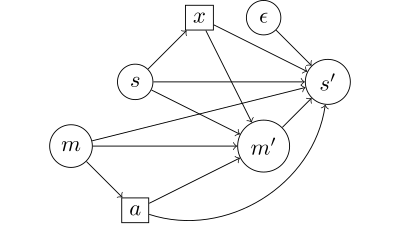

In [35]:
%%tikz -f svg
\usetikzlibrary{shapes}

\node[shape=circle,draw=black] (m) at (0,1) {$m$};

\node[shape=rectangle,draw=black] (a) at (1,0) {$a$};

\node[shape=circle,draw=black] (m_) at (3,1) {$m'$};

\node[shape=circle,draw=black] (s) at (1,2) {$s$};

\node[shape=rectangle,draw=black] (x) at (2,3) {$x$};
                                
\node[shape=circle,draw=black] (s_) at (4,2) {$s'$};

\node[shape=circle,draw=black] (epsilon) at (3,3) {$\epsilon$};

\path [->] (m) edge node[left] {} (a);
\path [->] (m) edge node[left] {} (m_);
\path [->] (a) edge node[left] {} (m_);
\path [->] (s) edge node[left] {} (s_);
\path [->] (s) edge node[left] {} (x);
\path [->] (x) edge node[left] {} (s_);
\path [->] (s) edge node[left] {} (m_);
\path [->] (x) edge node[left] {} (m_);
\path [->] (m) edge node[left] {} (s_);
\path [->] (a) edge [bend right = 50] node[left] {} (s_);
\path [->] (m_) edge node[left] {} (s_);
\path [->] (epsilon) edge node[left] {} (s_);


### A graphical notation

Pablo imagines a graphical representation of these games which is a compression of the "extensive form" event tree.

The nodes of this graph are elements of the discrete state space $m \in M$.

- forward edges: transitions
- backward edges: information needed for solution (like arbitrage, value)



### p-Stages

Pablo's version of a stage, **p-stage**, is a constraint on a subset of the 'event space', $C \subset M$.

One would write in math:

$$\forall m \in C, m' \in C, ...$$

And define continuous state and action spaces $\mathcal{S}, \mathcal{X}$ and transition functions $g, s'$ with respect to these subsets.

There will also need to be definitions for _transitions between_ p-stages, i.e.

$$\forall m \in C_1, m' \in C_2, ...$$

If there are $n$ defined **p-stages**, then $n^2$ subproblem definitions will need to be provided, unless the problem is sparse.

### Frames

Pablo calls "frames" an additional "node" inserted into this graphical notation.

A frame inroduces no new information, by which he means it must be prior to the introduction of new exogenous shocks $\epsilon$.

Exogenous Gridpoints Method exploits the introduction of a 'frame' in this sense by providing a 'post-state' event.

## Roadmap

### Prior Work

#### DYNARE

The class of problems it can solve:
 - perfect foresight
 - indentical problems in time
 - smoothness
 

### HARK 1.0

Herein we define the class of problems that we would like to support as of HARK 1.0.

We will define this in terms of the formal definitions listed above.

#### Monte Carlo Simulation

HARK uses Monte Carlo methods for the simulations.

#### Expectation Calculation Solutions

HARK uses expectation calculation in policy iteration for its solutions.

#### Shocks, State, Control, and Reward variables

Here, there are threes kinds of variables: shocks ($\phi$, $\psi$, ...), state ($a$, $b$, ...)  and control ($c$ and $\PortShare$).

There is also another kind of value, a reward or utility value that in this case is dependent on a control variable.

#### Finite Horizon iteration

Repeat a problem a finite number of time $T$.

#### Backwards induction

For each control variable, compute the optimal policy.

This is done through the calculation of the Bellman equation:

$$V(x) = \text{max}_{a \in \Gamma(a)} F(x,a) + \beta V(T(x,a))  $$

Where $\Gamma$ are constraints on the actions available and $T$ is the transition function to the next state.

Note in this formulation $a$ and $x$ are considered in terms of the broader classes of State and Action 

Compute this with a time adjusted value function 



#### Market equilibria

Multiple agents interacting with a Market, with rational expectations of the behavior of the market.

The current HARK class uses the Monte Carlo simulation to compute the rational expectations.

### HARK 2.0

Herein we define the class of problems that we would like to support as of HARK 2.0.

We will define this in terms of the formal definitions listed above.

We anticipate combining the scope of Dolo and HARK 1.0 into HARK 2.0


## Prior work

### Modeling different kinds of variables

Koller and Milch (2003) take the approach in their Multi-Agent Influence Diagrams (MAIDs) of using:
 - ovals for Chance variables or "decisions by nature"
 - rectangles for Decision variables (roughly equivalent to Control variables here)
 - diamonds for Utility variables, which correspond to utility gained by the agents.
 
 We can adapt this to the portfolio choice model as follows:


## Tools

There exist a number of tools that are designed for flexible notation for visualizing [probabilistic graphical models](http://www.utstat.toronto.edu/~rsalakhu/sta4273/notes/Lecture4.pdf) (see also [Koller and Friedman, 2009](https://djsaunde.github.io/read/books/pdfs/probabilistic%20graphical%20models.pdf))


### tikz BayesNet

https://github.com/jluttine/tikz-bayesnet

* LaTeX, builds on [Tikz](https://es.overleaf.com/learn/latex/TikZ_package)
* Plate notation
* Can handle factor graphs

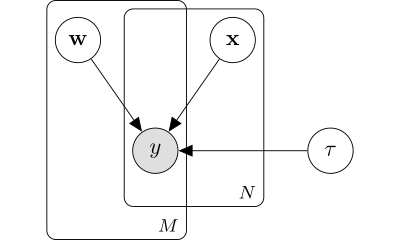

In [14]:
%%tikz -f svg
\usetikzlibrary{bayesnet}

% Define nodes
\node[obs]                               (y) {$y$};
\node[latent, above=of y, xshift=-1.2cm] (w) {$\mathbf{w}$};
\node[latent, above=of y, xshift=1.2cm]  (x) {$\mathbf{x}$};
\node[latent, right=2cm of y]            (t) {$\tau$};

 % Connect the nodes
\edge {x,w,t} {y} ; %

% Plates
\plate {yx} {(x)(y)} {$N$} ;
\plate {} {(w)(y)(yx.north west)(yx.south west)} {$M$} ;



### Daft

https://docs.daft-pgm.org/en/latest/

* Python based, used `matplotlib`
* Programmatic graph definition is nice
* built-in distinction between 'observed' and 'unobserved' variable




### GraphViz

https://stackoverflow.com/a/16334517

* Most flexible
* not LaTeX native
* Requires additional C dependencies

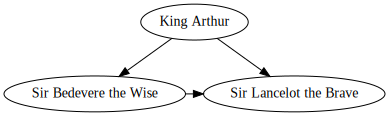

In [15]:
import graphviz as gv

dot = gv.Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

dot

## References

Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

Koller, D., & Milch, B. (2003). Multi-agent influence diagrams for representing and solving games. Games and economic behavior, 45(1), 181-221.

Koller, D., & Friedman, N. (2009). Probabilistic graphical models: principles and techniques. MIT press.

Kim, S. H., & Kose, M. A. (2003). Dynamics of open-economy business-cycle models: role of the discount factor. Macroeconomic Dynamics, 7(2), 263.

Mansour and Singh (2013), On the Complexity of Policy Iteration, https://arxiv.org/abs/1301.6718

Powell, W. B. (2007). Approximate Dynamic Programming: Solving the curses of dimensionality (Vol. 703). John Wiley & Sons.

White, M. N. (2015). The method of endogenous gridpoints in theory and practice. Journal of Economic Dynamics and Control, 60, 26-41.

### quantecon on time iteration

Wilbur John Coleman. Solving the Stochastic Growth Model by Policy-Function Iteration. Journal of Business & Economic Statistics, 8(1):27–29, 1990.

https://julia.quantecon.org/dynamic_programming/coleman_policy_iter.html

### llorracc solving micro dsops
https://llorracc.github.io/SolvingMicroDSOPs

building on Carrolll EGM

Kabukçuoğlu, A., & Martínez-García, E. (2020). A Generalized Time Iteration Method for Solving Dynamic Optimization Problems with Occasionally Binding Constraints. Computational Economics, 1-26.


### Dolo

http://spencerlyon.com/files/dolo_cef.pdf

### other

http://people.duke.edu/~acb8/notes1.pdf

http://w4.stern.nyu.edu/economics/docs/workingpapers/2005/BRZ%20palgrave.pdf

https://www.sas.upenn.edu/~jesusfv/Lecture_SM_1_VFI.pdf